In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from matplotlib.pyplot import MultipleLocator
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter

In [2]:
import pandas as pd
from mpl_toolkits.basemap import Basemap
import netCDF4 as nc
import cartopy.mpl.gridliner 
# import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.mpl.ticker as cticker
import cartopy.io.shapereader as shpreader
import cartopy.mpl.ticker as cticker
from matplotlib import rcParams

from matplotlib import colors,cm
import matplotlib as mpl
import cmaps
from matplotlib.colors import ListedColormap 
from scipy.stats import pearsonr

file_vwnd = './vwnd.mon.mean.nc'
file_uwnd = './uwnd.mon.mean.nc'
dataset_vwnd = nc.Dataset(file_vwnd)
dataset_uwnd = nc.Dataset(file_uwnd)
# vwnd(time, level, lat, lon) current shape = (904, 17, 73, 144)
vlon, vlat = dataset_vwnd.variables['lon'], dataset_vwnd.variables['lat']
vtime = dataset_vwnd.variables['time']
vlevel =dataset_vwnd.variables['level']
vwnd = dataset_vwnd.variables['vwnd']

ulon, ulat = dataset_uwnd.variables['lon'], dataset_vwnd.variables['lat']
utime = dataset_uwnd.variables['time']
ulevel =dataset_uwnd.variables['level']
uwnd = dataset_uwnd.variables['uwnd']

In [3]:
def num_month_12toNext4(a):
    num_months = (a - 1948) * 12 
    start = num_months - 1
    end = start + 5
    if start <= 0:
        return print("Out Break!")
    else:
        return start, end

def wind_mean(start, end, wind):
    '''
    计算每一年的风速平均值
    输入开始月份，结束月份，风速
    返回本年平均风速
    '''
    sum_months = np.zeros(wind[:1,0:1].data[0][:,:].shape, dtype=float, order='C')
    num_month = end - start
    for i in range(start, end): 
        tmp_vlevel_850 = wind[i:i+1,2:3].data[0][:,:][0]
        sum_months += tmp_vlevel_850
    return sum_months/num_month

In [5]:
def phase_mean(startYear, endYear, wind):
    """
    输入开始年，结束年，风速
    返回这个阶段风的平均值
    """
    sum_months = np.zeros(wind[:1,0:1].data[0][:,:].shape, dtype=float, order='C')
    for year in range(startYear, endYear):
        start_tmp, end_tmp = num_month_12toNext4(year)
        # 计算当前年的年平均风速
        wind_sum = wind_mean(start_tmp, end_tmp, wind)
        # 进行累加
        sum_months += wind_sum
    # 求风速平均值
    phase_wind_mind = sum_months / (endYear - startYear)
    return phase_wind_mind

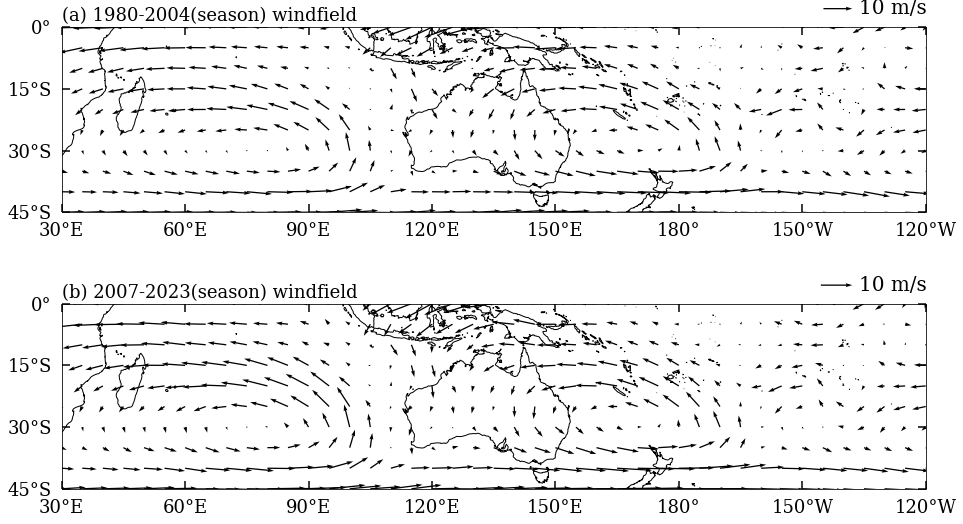

In [6]:
config = {
    "font.family": 'serif',
    "font.size": 12,
    "mathtext.fontset":'stix',
    'axes.unicode_minus': False 
         }
rcParams.update(config)
X,Y = np.meshgrid(vlon,vlat)

#figure和ax设置
fig = plt.figure(figsize=(12,8))
proj = ccrs.PlateCarree(central_longitude=180)

leftlon, rightlon, lowerlat, upperlat = (30,240,-45,0)
region = [leftlon, rightlon, lowerlat, upperlat]
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()

# ===============图1============
ax = plt.axes([0, 0.08, 1, 1], projection=proj)
ax.set_extent(region, crs = ccrs.PlateCarree())  #设置区域与需要画图的区域范围一致
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))  #海岸线
land = cfeature.NaturalEarthFeature('physical','land','50m',edgecolor='face',facecolor=cfeature.COLORS['land'])

ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

#风场图（调整间距）
#取1980-2004年次年1月到当年4月平均风速时刻level=850的u,v风速
u0 = phase_mean(1980, 2004, uwnd)[0] # 1980
v0 = phase_mean(1980, 2004, vwnd)[0]
q0 = ax.quiver(X[::2,::2],Y[::2,::2],u0[::2,::2],v0[::2,::2],
                width = 0.0015,
                scale = 300,
                color='k')  #调整间距
#添加箭头（q，位置左右，位置上下，要显示的风速（10m/s）,label，label在箭头右侧，以axes为坐标系，字体大小）
ax.quiverkey(q0, 0.915, 1.1, 10, '10 m/s', labelpos='E',coordinates='axes',fontproperties={'size':20})

#刻度设置
ax.set_xticks(np.arange(30,241,30), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-45,1,15), crs=ccrs.PlateCarree())

ax.xaxis.set_major_formatter(LongitudeFormatter())  #刻度格式转换为经纬度样式
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.tick_params(axis='x',top=True,which='major',direction='in',length=8,width=1.5,labelsize=18,pad=10)  #刻度样式
ax.tick_params(axis='y',right=True,which='major',direction='in',length=8,width=1.5,labelsize=18,pad=10)
ax.set_title('(a) 1980-2004(season) windfield',loc='left',fontsize =18)



# ===============图2============
ax1 = plt.axes([0, -0.40, 1, 1], projection=proj)
ax1.set_extent(region, crs = ccrs.PlateCarree())  #设置区域与需要画图的区域范围一致
ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))  #海岸线
land = cfeature.NaturalEarthFeature('physical','land','50m',edgecolor='face',facecolor=cfeature.COLORS['land'])

ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

#风场图（调整间距）
#取1980-2004年次年1月到当年4月平均风速时刻level=850的u,v风速
u1 = phase_mean(2007, 2024, uwnd)[0]
v1 = phase_mean(2007, 2024, vwnd)[0]
q1 = ax1.quiver(X[::2,::2],Y[::2,::2],u1[::2,::2],v1[::2,::2],
                width = 0.0015, #箭头宽度
                scale = 275, # 箭头长短 数字约小箭头越长
                color='k')  #调整间距
#添加箭头（q，位置左右，位置上下，要显示的风速（10m/s）,label，label在箭头右侧，以axes为坐标系，字体大小）
ax1.quiverkey(q1, 0.915, 1.1, 10, '10 m/s', labelpos='E',coordinates='axes',fontproperties={'size':20})

#刻度设置
ax1.set_xticks(np.arange(30,241,30), crs=ccrs.PlateCarree())
ax1.set_yticks(np.arange(-45,1,15), crs=ccrs.PlateCarree())

ax1.xaxis.set_major_formatter(LongitudeFormatter())  #刻度格式转换为经纬度样式
ax1.yaxis.set_major_formatter(LatitudeFormatter())
ax1.tick_params(axis='x',top=True,which='major',direction='in',length=8,width=1.5,labelsize=18,pad=10)  #刻度样式
ax1.tick_params(axis='y',right=True,which='major',direction='in',length=8,width=1.5,labelsize=18,pad=10)
ax1.set_title('(b) 2007-2023(season) windfield',loc='left',fontsize =18)


#标题
# plt.suptitle('1980-2023',fontsize=20,y=0.85)
plt.savefig('wind_trend.png', dpi=600, bbox_inches='tight',pad_inches = 0.2)
plt.show()
